In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/code/uchicago/sociohydro/sim/meanField/SchellingMF`


In [2]:
using SchellingMF
using LinearAlgebra
using Distributions
using StatsBase
using Printf
using HDF5
using JSON
using ProgressMeter
using Plots
using LaTeXStrings
using BenchmarkTools

In [119]:
Nx = 101
dx = 1.0
dt = 0.001
Nt = 10000
kaa = 0.0
kab = 0.0
kba = 0.0
kbb = 0.0
utility_params = [kaa, kab, kba, kbb]
D = 0.1
Γ = 0.0
ϕA0 = ϕB0 = 0.25
δϕA0 = δϕB0 = 0.05
snapshot = 500
periodic = true
savepath = "/Users/danny/Google Drive/My Drive/uchicago/sociohydro/2023-11-30_2DTest"

ϕA0 = zeros(Nx, Nx)
ϕB0 = zeros(Nx, Nx)
ϕA0[:, 51] .= 1.0
t_init = 0.0

ϕA, ϕB, t = run_simulation(ϕA0, ϕB0, t_init,
                           dx, Nx, dt, Nt,
                           utility_params,
                           snapshot, savepath,
                           periodic=periodic,
                           D=D, Γ=Γ)

Starting main loop...


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


([3.38254808532645e-41 3.2441923142525227e-43 … 3.2441923142525227e-43 3.38254808532645e-41; 3.38254808532645e-41 3.2441923142525227e-43 … 3.2441923142525227e-43 3.38254808532645e-41; … ; 3.38254808532645e-41 3.2441923142525227e-43 … 3.2441923142525227e-43 3.38254808532645e-41; 3.38254808532645e-41 3.2441923142525227e-43 … 3.2441923142525227e-43 3.38254808532645e-41], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 9.999999999999897)

In [120]:
ϕA, ϕB, x, y, t, params = load_data(savepath);

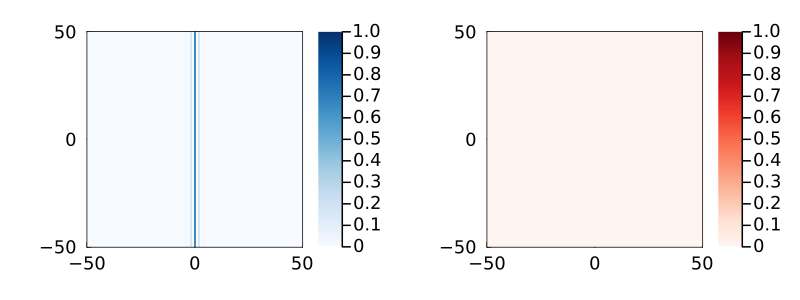

In [127]:
ha = heatmap(x, y, ϕA[:, :, end], cmap=:Blues, clim=(0, 1))
hb = heatmap(x, y, ϕB[:, :, end], cmap=:Reds, clim=(0, 1))
plot(ha, hb, layout=(1, 2),
     aspect_ratio=1, size=(800, 300),
     thickness_scaling=1.5,
     xlim=(minimum(x), maximum(x)), 
     ylim=(minimum(y), maximum(y)),
     xticks=[minimum(x), 0, maximum(x)],
     yticks=[minimum(y), 0, maximum(y)],
     framestyle=:box)

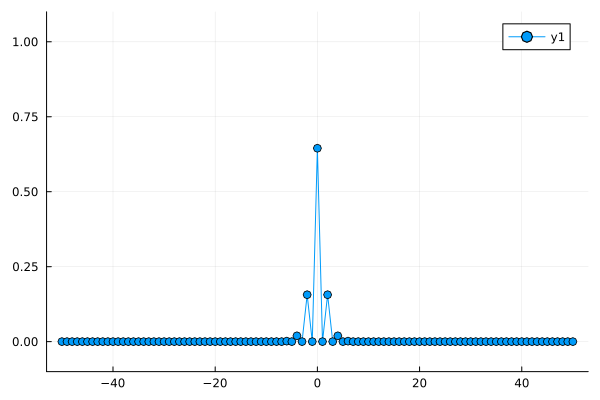

In [123]:
plot(x, ϕA[50, :, end], marker=:o, ylim=[-0.1, 1.1])

In [126]:
for x in [1:2 9:10]
    println(x)
end

1
2
9
10


# test gradients

In [2]:
dx = 0.1
x = -2π:dx:2π-dx
y = -2π:dx:2π-dx
xx = ones(length(y)) * x';
yy = y * ones(length(x))';

Nx = length(x);

In [5]:
function calc_grad(field::Array{T, 2}, dx::T, periodic::Bool;
                   enforce_bcs::Bool=true, bcval::T = 0.0) where T<:AbstractFloat
    ∇xfield = similar(field)
    ∇yfield = similar(field)
    Ny, Nx = size(field)

    # central differences in center region
    for x in 2:Nx-1
        for y in 2:Ny-1
            ∇xfield[y, x] = (field[y, x+1] - field[y, x-1]) / 2
            ∇yfield[y, x] = (field[y+1, x] - field[y-1, x]) / 2
        end
    end

    if periodic # do central differences at edges
        ### corners ###
        # bottom left
        ∇xfield[1, 1] = (field[1, 2] - field[1, Nx]) / 2
        ∇yfield[1, 1] = (field[2, 1] - field[Ny, 1]) / 2

        # bottom right
        ∇xfield[1, Nx] = (field[1, 1] - field[1, Nx-1]) / 2
        ∇yfield[1, Nx] = (field[2, Nx] - field[Ny, Nx]) / 2

        # top left
        ∇xfield[Ny, 1] = (field[Ny, 2] - field[Ny, Nx]) / 2
        ∇yfield[Ny, 1] = (field[1, 1] - field[Ny-1, 1]) / 2

        # top right
        ∇xfield[Ny, Nx] = (field[Ny, 1] - field[Ny, Nx-1]) / 2
        ∇yfield[Ny, Nx] = (field[1, Nx] - field[Ny-1, Nx]) / 2

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇xfield[y, 1] = (field[y, 2] - field[y, Nx]) / 2
            ∇yfield[y, 1] = (field[y+1, 1] - field[y-1, 1]) / 2
            # right
            ∇xfield[y, Nx] = (field[y, 1] - field[y, Nx-1]) / 2
            ∇yfield[y, Nx] = (field[y+1, Nx] - field[y-1, Nx]) / 2
        end
        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇xfield[1, x] = (field[1, x+1] - field[1, x-1]) / 2
            ∇yfield[1, x] = (field[2, x] - field[Ny, x]) / 2
            # top
            ∇xfield[Ny, x] = (field[Ny, x+1] - field[Ny, x-1]) / 2
            ∇yfield[Ny, x] = (field[1, x] - field[Ny-1, x]) / 2
        end

    else # do forward/backward differences at ends
        ### corners ###
        # bottom left
        ∇xfield[1, 1] = field[1, 2] - field[1, 1]
        ∇yfield[1, 1] = field[2, 1] - field[1, 1]

        # bottom right
        ∇xfield[1, Nx] = field[1, Nx] - field[1, Nx-1]
        ∇yfield[1, Nx] = field[2, Nx] - field[1, Nx]

        # top left
        ∇xfield[Ny, 1] = field[Ny, 2] - field[Ny, 1]
        ∇yfield[Ny, 1] = field[Ny, 1] - field[Ny-1, 1]

        # top right
        ∇xfield[Ny, Nx] = field[Ny, Nx] - field[Ny, Nx-1]
        ∇yfield[Ny, Nx] = field[Ny, Nx] - field[Ny-1, Nx]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇xfield[y, 1] = field[y, 2] - field[y, 1]
            ∇yfield[y, 1] = (field[y+1, 1] - field[y-1, 1]) / 2
            # right
            ∇xfield[y, Nx] = field[y, Nx] - field[y, Nx - 1]
            ∇yfield[y, Nx] = (field[y+1, Nx] - field[y-1, Nx]) / 2
        end
        #horizontal
        for x in 2:Nx-1
            # bottom
            ∇xfield[1, x] = (field[1, x+1] - field[1, x-1]) / 2
            ∇yfield[1, x] = field[2, x] - field[1, x]
            # top
            ∇xfield[Ny, x] = (field[Ny, x+1] - field[Ny, x-1]) / 2
            ∇yfield[Ny, x] = field[Ny, x] - field[Ny-1, x]
        end

        # enforce boundary conditions
        if enforce_bcs
            # left
            ∇xfield[1:end, 1] .= bcval
            # right
            ∇xfield[1:end, end] .= bcval
            # bottom
            ∇yfield[1, 1:end] .= bcval
            # top
            ∇yfield[end, 1:end] .= bcval
        end
    end

    return ∇xfield ./ dx, ∇yfield ./ dx
end

function calc_lap(field::Array{T, 2}, dx::T, periodic::Bool) where T<:AbstractFloat
    ∇²field = similar(field)
    Ny, Nx = size(field)

    # central differences in center region
    # Do order: up, right, center, down, left
    for x in 2:Nx-1
        for y in 2:Ny-1
            ∇²field[y, x] = field[y+1, x] + field[y, x+1] - 4 * field[y, x] + field[y-1, x] + field[y, x-1]
        end
    end

    if periodic # do central differences at edges
        ### corners ###
        # bottom left
        ∇²field[1, 1] = field[2, 1] + field[1, 2] - 4 * field[1, 1] + field[Ny, 1] + field[1, Nx]

        # bottom right
        ∇²field[1, Nx] = field[2, Nx] + field[1, 1] - 4 * field[1, Nx] + field[Ny, Nx] + field[1, Nx-1]

        # top left
        ∇²field[Ny, 1] = field[1, 1] + field[Ny, 2] - 4 * field[Ny, 1] + field[Ny-1, 1] + field[Ny, Nx]

        # top right
        ∇²field[Ny, Nx] = field[1, Nx] + field[Ny, 1] - 4 * field[Ny, Nx] + field[Ny-1, Nx] + field[Ny, Nx-1]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇²field[y, 1] = field[y+1, 1] + field[y, 2] - 4 * field[y, 1] + field[y-1, 1] + field[y, Nx]
            # right
            ∇²field[y, Nx] = field[y+1, Nx] + field[y, 1] - 4 * field[y, Nx] + field[y-1, Nx] + field[y, Nx-1]
        end

        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇²field[1, x] = field[2, x] + field[1, x+1] - 4 * field[1, x] + field[Ny, x] + field[1, x-1]
            # top
            ∇²field[Ny, x] = field[1, x] + field[Ny, x+1] - 4 * field[Ny, x] + field[Ny-1, x] + field[Ny, x-1]
        end

    else # do forward/backward differences at edges
        ### corners ###
        # bottom left
        ∇²field[1, 1] = field[3, 1] - 2 * field[2, 1] + 2 * field[1, 1] - 2 * field[1, 2] + field[1, 3]

        # bottom right
        ∇²field[1, Nx] = field[1, Nx-2] - 2 * field[1, Nx-1] + 2 * field[1, Nx] - 2 * field[2, Nx] + field[3, Nx]

        # top left
        ∇²field[Ny, 1] = field[Ny-2, 1] - 2 * field[Ny-1, 1] + 2 * field[Ny, 1] - 2 * field[Ny, 2] + field[Ny, 3]

        # top right
        ∇²field[Ny, Nx] = field[Ny, Nx-2] - 2 * field[Ny, Nx-1] + 2 * field[Ny, Nx] - 2 * field[Ny-1, Nx] + field[Ny-2, Nx]

        ### edges ###
        # vertical
        for y in 2:Ny-1
            # left
            ∇²field[y, 1] = field[y+1, 1] - field[y, 1] + field[y-1, 1] - 2 * field[y, 2] + field[y, 3]
            # right
            ∇²field[y, Nx] = field[y+1, Nx] - field[y, Nx] + field[y-1, Nx] - 2 * field[y, Nx-1] + field[y, Nx-2]
        end

        # horizontal
        for x in 2:Nx-1
            # bottom
            ∇²field[1, x] = field[1, x-1] - field[1, x] + field[1, x+1] - 2 * field[2, x] + field[3, x]
            # top
            ∇²field[Ny, x] = field[Ny, x-1] - field[Ny, x] + field[Ny, x+1] - 2 * field[Ny-1, x] + field[Ny-2, x]
        end
    end

    return ∇²field ./ dx^2
end


function calc_grad3(field::Array{T, 2}, dx::T, periodic::Bool;
                    enforce_bcs::Bool=true, bcval::T=0.0) where T<:AbstractFloat
    ∇²field = calc_lap(field, dx, periodic)
    ∇³xfield, ∇³yfield = calc_grad(∇²field, dx, periodic;
                                   enforce_bcs=enforce_bcs,
                                   bcval=bcval)
    return ∇³xfield, ∇³yfield
end


function calc_div(fieldx::Array{T, 2}, fieldy::Array{T, 2}, dx::T, periodic::Bool) where T<:AbstractFloat
    ∂x_fieldx, ∂y_fieldx = calc_grad(fieldx, dx, periodic)
    ∂x_fieldy, ∂y_fieldy = calc_grad(fieldy, dx, periodic)
    return ∂x_fieldx + ∂y_fieldy
end

calc_div (generic function with 1 method)

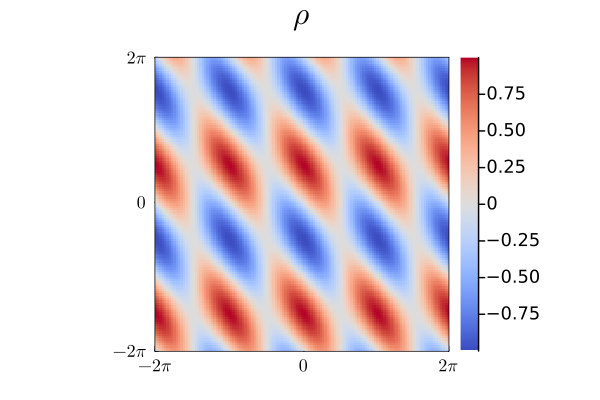

In [25]:
rho = @. cos(xx) * sin(yy + xx);
rhox_true = @. cos(xx) * cos(xx + yy) - sin(xx) * sin(yy + xx)
rhoy_true = @. cos(xx) * cos(xx + yy)
rholap_true = @. -2 * cos(xx + yy) * sin(xx) - 3 * cos(xx) * sin(xx + yy)
rhoxxx_true = @. 5 * (sin(xx) * sin(xx + yy) - cos(xx) * cos(xx + yy))
rhoyyy_true = @. 2 * sin(xx) * sin(xx + yy) - 3 * cos(xx) * cos(xx + yy)

rhox, rhoy = calc_grad(rho, dx, false)
rholap = calc_lap(rho, dx, false)
rhoxxx, rhoyyy = calc_grad3(rho, dx, false);

h = heatmap(x, y, rho, cmap=:coolwarm, title=L"\rho")
plot(h, thickness_scaling=1.5, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

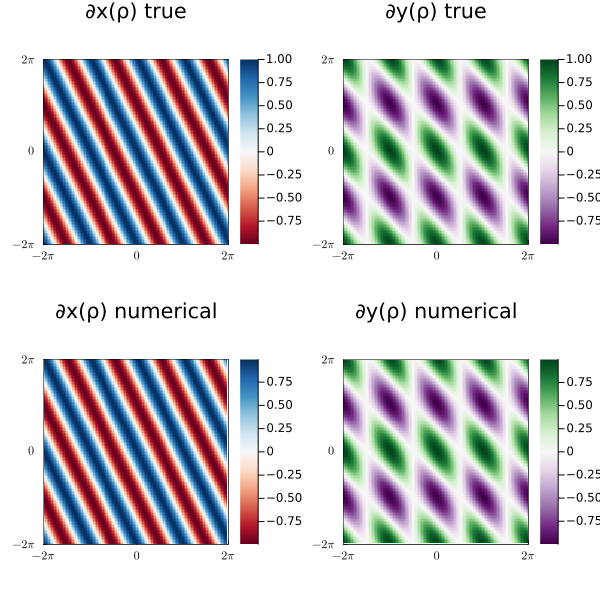

In [27]:
hx = heatmap(x, y, rhox, cmap=:RdBu, title="∂x(ρ) numerical")
hxtrue = heatmap(x, y, rhox_true, cmap=:RdBu, title="∂x(ρ) true")
hy = heatmap(x, y, rhoy, cmap=:PRGn, title="∂y(ρ) numerical")
hytrue = heatmap(x, y, rhoy_true, cmap=:PRGn, title="∂y(ρ) true")
l = @layout([[a; b] [d; e]])
plot(hxtrue, hx, hytrue, hy, layout=l, size=(600, 600),
     thickness_scaling=1, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

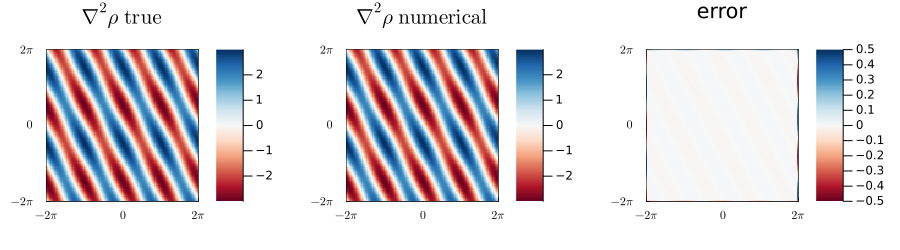

In [39]:
hlap = heatmap(x, y, rholap, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{numerical}")
hlaptrue = heatmap(x, y, rholap_true, cmap=:RdBu, title=L"\nabla^2 \rho \ \mathrm{true}")
herror = heatmap(x, y, rholap - lap_rho_true, clim=(-0.5, 0.5), cmap=:RdBu, title="error")
l = @layout([a b c])
plot(hlaptrue, hlap, herror, layout=l, size=(900, 250),
     thickness_scaling=1.0, aspect_ratio=1, framestyle=:box,
     xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
     xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
     yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

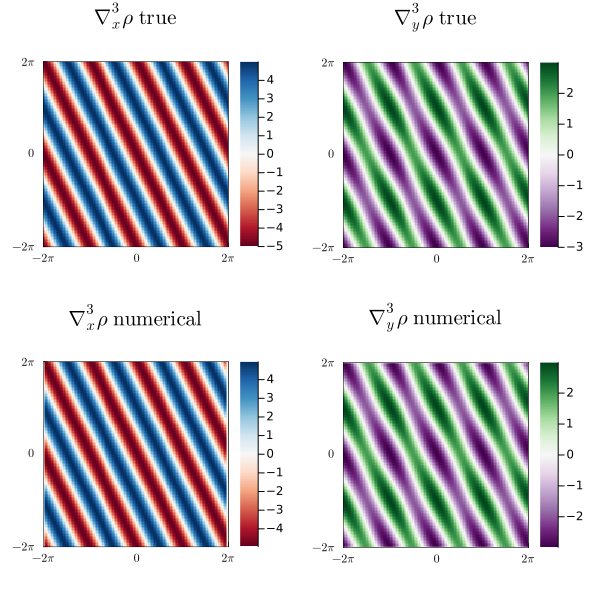

In [40]:
hx = heatmap(x, y, rhoxxx, cmap=:RdBu, title=L"\nabla^3_x \rho \ \mathrm{numerical}")
hxtrue = heatmap(x, y, rhoxxx_true, cmap=:RdBu, title=L"\nabla^3_x \rho \ \mathrm{true}")
hy = heatmap(x, y, rhoyyy, cmap=:PRGn, title=L"\nabla^3_y \rho \ \mathrm{numerical}")
hytrue = heatmap(x, y, rhoyyy_true, cmap=:PRGn, title=L"\nabla^3_y \rho \ \mathrm{true}")
l = @layout([[a; b] [d; e]])
plot(hxtrue, hx, hytrue, hy, layout=l, size=(600, 600),
     thickness_scaling=1, aspect_ratio=1, framestyle=:box,
         xlim=(minimum(x), maximum(x)), ylim=(minimum(y), maximum(y)),
         xticks=([minimum(x), 0, maximum(x)],[L"-2\pi", L"0", L"2\pi"]),
         yticks=([minimum(y), 0, maximum(y)],[L"-2\pi", L"0", L"2\pi"]))

In [42]:
rand(Uniform(-1, 1), 2, 2)

2×2 Matrix{Float64}:
 -0.625318  -0.104419
 -0.438994  -0.723534